In [1]:
import os
import pandas as pd 
import numpy as np
import datetime as dt 
import math
import tensorflow as tf
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, mean_poisson_deviance, mean_gamma_deviance, accuracy_score 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, GRU, Dropout, Dense,LSTM, Attention,Bidirectional,MultiHeadAttention,Attention, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow.keras
import matplotlib.pyplot as plt 
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as xp
import plotly.subplots as sp
tf.test.gpu_device_name()

''

In [3]:
data = pd.read_csv('GOOG.csv')

In [8]:
data["date"]=pd.to_datetime(data.date)
data.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2018-10-22 00:00:00+00:00,1101.16,1112.23,1091.00,1103.06,1514220,55.0580,55.6115,54.5500,55.1530,30284400,0.0,1.0
1,GOOG,2018-10-23 00:00:00+00:00,1103.69,1107.89,1070.00,1080.89,1848654,55.1845,55.3945,53.5000,54.0445,36973080,0.0,1.0
2,GOOG,2018-10-24 00:00:00+00:00,1050.71,1106.12,1048.74,1104.25,1982430,52.5355,55.3060,52.4370,55.2125,39648600,0.0,1.0
3,GOOG,2018-10-25 00:00:00+00:00,1095.57,1110.98,1069.55,1071.79,2545839,54.7785,55.5490,53.4775,53.5895,50916780,0.0,1.0
4,GOOG,2018-10-26 00:00:00+00:00,1071.47,1106.53,1034.09,1037.03,4187586,53.5735,55.3265,51.7045,51.8515,83751720,0.0,1.0


In [28]:
data.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,GOOG,2023-10-13 00:00:00+00:00,138.58,141.340,137.9700,140.65,19447565,138.58,141.340,137.9700,140.65,19447565,0.0,1.0
1253,GOOG,2023-10-16 00:00:00+00:00,140.49,140.905,139.3200,139.73,17345556,140.49,140.905,139.3200,139.73,17345556,0.0,1.0
1254,GOOG,2023-10-17 00:00:00+00:00,140.99,141.250,138.5287,140.03,17424024,140.99,141.250,138.5287,140.03,17424024,0.0,1.0
1255,GOOG,2023-10-18 00:00:00+00:00,139.28,141.990,138.7050,140.75,18304869,139.28,141.990,138.7050,140.75,18304869,0.0,1.0
1256,GOOG,2023-10-19 00:00:00+00:00,138.98,141.005,138.6000,139.80,21831181,138.98,141.005,138.6000,139.80,21831181,0.0,1.0


In [16]:
close=data[['date','close']]
pred_close=close.copy()
del close['date']
close.head()

,close
0,1101.16
1,1103.69
2,1050.71
3,1095.57
4,1071.47


In [17]:

#Normalizing
scalar=MinMaxScaler(feature_range=(0,1))
close=scalar.fit_transform(np.array(close).reshape(-1,1))
close.shape
#split train and test data
split_size=0.6
time_step=15
train,test=close[0:int(len(close)*split_size),:], close[int(len(close)*split_size):,:]
print(train.shape,test.shape)
#transform to time-series-like data
def time_series(data,time_stemp):
    X=[]
    y=[]
    for i in range(len(data)-time_step-1):
        a=data[i:(i+time_stemp),0]
        X.append(a)
        y.append(data[i+time_stemp])
    return np.array(X),np.array(y)
trainX,train_y=time_series(train,time_step)
testX,test_y=time_series(test,time_step)

print(trainX.shape,train_y.shape)
print(testX.shape,test_y.shape)

# reshape input to be [samples, time steps, features] which is required for LSTM
trainX =trainX.reshape(trainX.shape[0],trainX.shape[1] , 1)
testX = testX.reshape(testX.shape[0],testX.shape[1] , 1)

print("X_train: ", trainX.shape)
print("X_test: ", testX.shape)

(754, 1) (503, 1)
(738, 15) (738, 1)
(487, 15) (487, 1)
X_train:  (738, 15, 1)
X_test:  (487, 15, 1)


In [19]:
! pip install attention


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\varsh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [20]:
from attention import Attention
inputs=Input((time_step,1))
x=GRU(64,return_sequences=True)(inputs)
x=LSTM(32,return_sequences=True)(x)
x=Attention(32)(x)
x = Dense(32, activation="relu")(x)
x=Dropout(0.2)(x)
outputs=Dense(1)(x)
model=Model(inputs,outputs)   

optimizer=Adam(learning_rate=0.01,
    beta_1=0.9,
    beta_2=0.999)

model.compile(optimizer=optimizer,loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 1)]           0         
                                                                 
 gru (GRU)                   (None, 15, 64)            12864     
                                                                 
 lstm (LSTM)                 (None, 15, 32)            12416     
                                                                 
 attention (Attention)       (None, 32)                3072      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33    

In [21]:
callbacks = [tensorflow.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
history=model.fit(trainX,train_y,
                  epochs=200,
                  validation_data=(testX,test_y),
                  verbose=1,
                  batch_size=32,
                  callbacks=callbacks
                 )

Epoch 1/200
24/24 [==============================] - 3s 39ms/step - loss: 0.0398 - val_loss: 0.0083
Epoch 2/200
24/24 [==============================] - 0s 12ms/step - loss: 0.0069 - val_loss: 0.0154
Epoch 3/200
24/24 [==============================] - 0s 13ms/step - loss: 0.0067 - val_loss: 0.0104
Epoch 4/200
24/24 [==============================] - 0s 14ms/step - loss: 0.0061 - val_loss: 0.0152
Epoch 5/200
24/24 [==============================] - 0s 14ms/step - loss: 0.0042 - val_loss: 0.0110
Epoch 6/200
24/24 [==============================] - 0s 14ms/step - loss: 0.0038 - val_loss: 0.0137
Epoch 7/200
24/24 [==============================] - 0s 13ms/step - loss: 0.0038 - val_loss: 0.0411
Epoch 8/200
24/24 [==============================] - 0s 13ms/step - loss: 0.0068 - val_loss: 0.0452
Epoch 9/200
24/24 [==============================] - 0s 14ms/step - loss: 0.0059 - val_loss: 0.0750
Epoch 10/200
24/24 [==============================] - 0s 14ms/step - loss: 0.0023 - val_loss: 0.0398

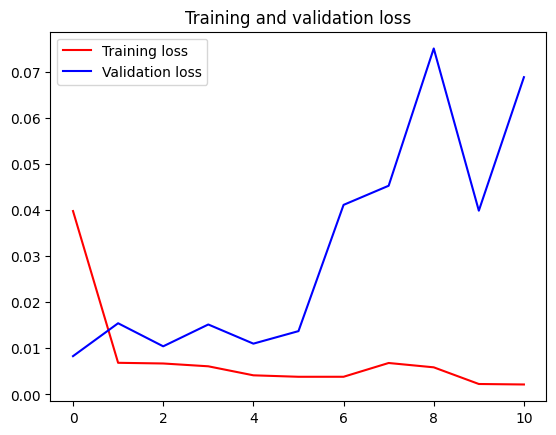

<Figure size 640x480 with 0 Axes>

In [22]:
#learning curves
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [23]:
train_predict=model.predict(trainX)
test_predict=model.predict(testX)
train_predict.shape, test_predict.shape

16/16 [==============================] - 0s 6ms/step


((738, 1), (487, 1))

In [24]:
# Transform back to original form
train_predict = scalar.inverse_transform(train_predict)
test_predict = scalar.inverse_transform(test_predict)
original_ytrain = scalar.inverse_transform(train_y.reshape(-1,1)) 
original_ytest = scalar.inverse_transform(test_y.reshape(-1,1))

In [25]:
look_back=time_step
trainPredictPlot = np.empty_like(close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

Train predicted data:  (1257, 1)


In [26]:
testPredictPlot = np.empty_like(close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(close)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

Test predicted data:  (1257, 1)


In [27]:
plotdf = pd.DataFrame({'date': pred_close['date'],
                       'original_close': pred_close['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = xp.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})

fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [29]:
import yfinance as yf
goog = yf.Ticker("GOOG")
goog_df = goog.history(period="max")
goog_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-08-19 00:00:00-04:00,2.490664,2.591785,2.390042,2.499133,897427216,0.0,0.0
2004-08-20 00:00:00-04:00,2.515820,2.716817,2.503118,2.697639,458857488,0.0,0.0
2004-08-23 00:00:00-04:00,2.758411,2.826406,2.716070,2.724787,366857939,0.0,0.0
2004-08-24 00:00:00-04:00,2.770615,2.779581,2.579581,2.611960,306396159,0.0,0.0
2004-08-25 00:00:00-04:00,2.614201,2.689918,2.587302,2.640104,184645512,0.0,0.0


In [37]:
goog_df.reset_index(inplace=True)

In [65]:
goog_df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2004-08-19 00:00:00-04:00,2.490664,2.591785,2.390042,2.499133,897427216,0.0,0.0
1,2004-08-20 00:00:00-04:00,2.515820,2.716817,2.503118,2.697639,458857488,0.0,0.0
2,2004-08-23 00:00:00-04:00,2.758411,2.826406,2.716070,2.724787,366857939,0.0,0.0
3,2004-08-24 00:00:00-04:00,2.770615,2.779581,2.579581,2.611960,306396159,0.0,0.0
4,2004-08-25 00:00:00-04:00,2.614201,2.689918,2.587302,2.640104,184645512,0.0,0.0
...,...,...,...,...,...,...,...,...
4845,2023-11-16 00:00:00-05:00,136.960007,138.880005,136.080002,138.699997,17615100,0.0,0.0
4846,2023-11-17 00:00:00-05:00,137.820007,138.000000,135.479996,136.940002,25565300,0.0,0.0
4847,2023-11-20 00:00:00-05:00,135.500000,138.425003,135.490005,137.919998,19569400,0.0,0.0
4848,2023-11-21 00:00:00-05:00,137.940002,138.964996,137.705002,138.619995,17648100,0.0,0.0


In [66]:
pred_open=goog_df[['Date','Open']]
pred_open

,Date,Open
0,2004-08-19 00:00:00-04:00,2.490664
1,2004-08-20 00:00:00-04:00,2.515820
2,2004-08-23 00:00:00-04:00,2.758411
3,2004-08-24 00:00:00-04:00,2.770615
4,2004-08-25 00:00:00-04:00,2.614201
...,...,...
4845,2023-11-16 00:00:00-05:00,136.960007
4846,2023-11-17 00:00:00-05:00,137.820007
4847,2023-11-20 00:00:00-05:00,135.500000
4848,2023-11-21 00:00:00-05:00,137.940002


In [38]:
#split the csv with top 4345 rows in train csv and bottom 482 rows in test csv
goog_df_train = goog_df.iloc[:4345]
goog_df_test = goog_df.iloc[4345:]

In [39]:
goo=goog_df['Open']
goo

0         2.490664
1         2.515820
2         2.758411
3         2.770615
4         2.614201
           ...    
4845    136.960007
4846    137.820007
4847    135.500000
4848    137.940002
4849    139.100006
Name: Open, Length: 4850, dtype: float64

In [51]:

#Normalizing
scalar=MinMaxScaler(feature_range=(0,1))
goo=scalar.fit_transform(np.array(goo).reshape(-1,1))
goo.shape
#split train and test data
split_size=0.6
time_step=15
train,test=goo[0:int(len(goo)*split_size),:], goo[int(len(goo)*split_size):,:]
print(train.shape,test.shape)
#transform to time-series-like data
def time_series(goog_df,time_stemp):
    X=[]
    y=[]
    for i in range(len(goog_df)-time_step-1):
        a=goog_df[i:(i+time_stemp),0]
        X.append(a)
        y.append(goog_df[i+time_stemp])
    return np.array(X),np.array(y)
trainX,train_y=time_series(train,time_step)
testX,test_y=time_series(test,time_step)

print(trainX.shape,train_y.shape)
print(testX.shape,test_y.shape)

# reshape input to be [samples, time steps, features] which is required for LSTM
trainX =trainX.reshape(trainX.shape[0],trainX.shape[1] , 1)
testX = testX.reshape(testX.shape[0],testX.shape[1] , 1)

print("X_train: ", trainX.shape)
print("X_test: ", testX.shape)

(2910, 1) (1940, 1)
(2894, 15) (2894, 1)
(1924, 15) (1924, 1)
X_train:  (2894, 15, 1)
X_test:  (1924, 15, 1)


In [52]:
from attention import Attention
inputs=Input((time_step,1))
x=GRU(64,return_sequences=True)(inputs)
x=LSTM(32,return_sequences=True)(x)
x=Attention(32)(x)
x = Dense(32, activation="relu")(x)
x=Dropout(0.2)(x)
outputs=Dense(1)(x)
model=Model(inputs,outputs)   

optimizer=Adam(learning_rate=0.01,
    beta_1=0.9,
    beta_2=0.999)

model.compile(optimizer=optimizer,loss='mse')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 15, 1)]           0         
                                                                 
 gru_2 (GRU)                 (None, 15, 64)            12864     
                                                                 
 lstm_2 (LSTM)               (None, 15, 32)            12416     
                                                                 
 attention_2 (Attention)     (None, 32)                3072      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33  

In [53]:
callbacks = [tensorflow.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
history=model.fit(trainX,train_y,
                  epochs=200,
                  validation_data=(testX,test_y),
                  verbose=1,
                  batch_size=32,
                  callbacks=callbacks
                 )

Epoch 1/200


91/91 [==============================] - 4s 17ms/step - loss: 0.0021 - val_loss: 0.0076
Epoch 2/200
91/91 [==============================] - 1s 10ms/step - loss: 2.1859e-04 - val_loss: 0.0310
Epoch 3/200
91/91 [==============================] - 1s 11ms/step - loss: 1.6303e-04 - val_loss: 0.0198
Epoch 4/200
91/91 [==============================] - 1s 10ms/step - loss: 1.2792e-04 - val_loss: 0.0224
Epoch 5/200
91/91 [==============================] - 1s 10ms/step - loss: 1.7801e-04 - val_loss: 0.0259
Epoch 6/200
91/91 [==============================] - 1s 10ms/step - loss: 1.3051e-04 - val_loss: 0.0307
Epoch 7/200
91/91 [==============================] - 1s 10ms/step - loss: 1.3519e-04 - val_loss: 0.0295
Epoch 8/200
91/91 [==============================] - 1s 11ms/step - loss: 1.1185e-04 - val_loss: 0.0307
Epoch 9/200
91/91 [==============================] - 1s 11ms/step - loss: 1.4061e-04 - val_loss: 0.0184
Epoch 10/200
91/91 [==============================] - 1s 12ms/step - loss: 1.256

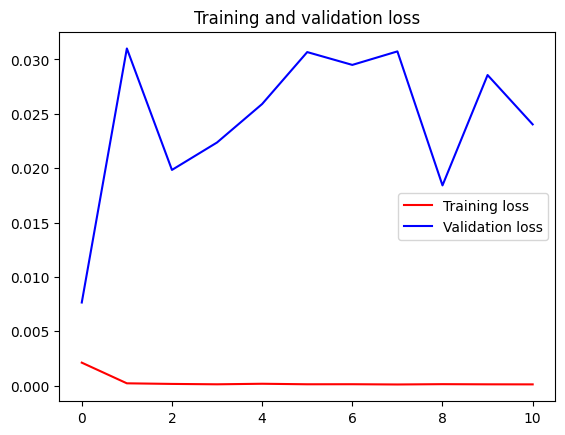

<Figure size 640x480 with 0 Axes>

In [57]:
#learning curves
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [58]:
train_predict=model.predict(trainX)
test_predict=model.predict(testX)
train_predict.shape, test_predict.shape

61/61 [==============================] - 0s 3ms/step


((2894, 1), (1924, 1))

In [80]:
train_predict

array([[0.01958146],
       [0.01957729],
       [0.01957677],
       ...,
       [0.225668  ],
       [0.22620562],
       [0.22620973]], dtype=float32)

In [79]:
# Transform back to original form
train_predict = scalar.inverse_transform(train_predict)
test_predict = scalar.inverse_transform(test_predict)
original_ytrain = scalar.inverse_transform(train_y.reshape(-1,1)) 
original_ytest = scalar.inverse_transform(test_y.reshape(-1,1))

In [59]:
# Transform back to original form
train_predict = scalar.inverse_transform(train_predict)
test_predict = scalar.inverse_transform(test_predict)
original_ytrain = scalar.inverse_transform(train_y.reshape(-1,1)) 
original_ytest = scalar.inverse_transform(test_y.reshape(-1,1))

In [60]:
look_back=time_step
trainPredictPlot = np.empty_like(goo)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

Train predicted data:  (4850, 1)


In [61]:
testPredictPlot = np.empty_like(goo)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(goo)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original open price','Train predicted open price','Test predicted open price'])

Test predicted data:  (4850, 1)


In [73]:
testPredictPlot.shape

(4850, 1)

In [74]:
trainPredictPlot.shape

(4850, 1)

In [75]:
train_predict

array([[0.01958146],
       [0.01957729],
       [0.01957677],
       ...,
       [0.225668  ],
       [0.22620562],
       [0.22620973]], dtype=float32)

In [77]:
test_predict

array([[0.23696837],
       [0.23753706],
       [0.23785013],
       ...,
       [0.7022074 ],
       [0.7051204 ],
       [0.70753163]], dtype=float32)

In [72]:
plotdf = pd.DataFrame({'Date': pred_open['Date'],
                       'original_open': pred_open['Open'],
                      'train_predicted_open': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_open': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = xp.line(plotdf,x=plotdf['Date'], y=[plotdf['original_open'],plotdf['train_predicted_open'],
                                          plotdf['test_predicted_open']],
              labels={'value':'Stock price','date': 'Date'})

fig.update_layout(title_text='Comparision between original open price vs predicted open price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Open Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()